## "Unsupervised discovery of visual object class hierarchies"
Sivic, J., Russell, B. C., Zisserman, A., Freeman, W. T., & Efros, A. A. (2008). Unsupervised discovery of visual object class hierarchies. 2008 IEEE Conference on Computer Vision and Pattern Recognition, 1–8. https://doi.org/10.1109/CVPR.2008.4587622

Make sure to run the following cell so that the dependencies are loaded!

In [78]:
!pip install -q matplotlib pillow networkx pygraphviz
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from notebooks.hierarchy_plotting import *
import os
os.chdir(os.getcwd() + '/notebooks')
%matplotlib inline

First, let's try to recreate figure #3 from the title reference (Sivic et al., 2008). The figure is the following:

![Sivic et al. 2008 Figure #3](figures/sivic_fig3.png)

So, the first thing we need to be able to do is generate our training set data, which will be composed of 'word' observations. To do so, we use the generative model for hLDA presented in the paper:

![Sivic et al. 2008 hLDA Graphical Model](figures/hlda_graphical_model.png)

To generate the visual words $\{w_i\}_{i=1}^N$, we need to first generate:
1. A set distributions of topics over words: $\{\beta_i\}_{i=1}^K$
1. A tree structure $T$ with depth $L$ containing $K$ topics
2. A path $\mathbf{c}$ of length $L$ through the tree for each image (document)
1. A topic distribution $\theta$ over the topics in the path for every image (document)

In Figure #3 of the Sivic paper, the $\beta$ distributions and $T$ are fixed, and we will replicate the same structure. Let's begin by representing the $\beta$ distributions, which show the word distribution of each topic.

In [79]:
def create_band(x=None, y=None, save=None):
    img = Image.new('L', (5, 5), color=255)
    pix = img.load()
    if x is not None:
        for i in range(img.height):
            pix[x, i] = 0
    if y is not None:
        for i in range(img.width):
            pix[i, y] = 0
    if save:
        plt.imsave(save + '.png', np.array(img), cmap='gray', vmin=0, vmax=255)
    return img


The `create_band()` function allows us to create an image of a single band, which will represent a topic. For example, to create a vertical band at x=1, we do the following:


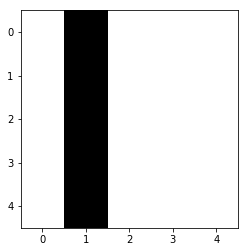

In [80]:
z1 = create_band(x=1, save='figures/z1')
plt.imshow(z1)

Let's enumerate the bands used in the hierarchy from Figure #3:

In [81]:
z2 = create_band(y=1, save='figures/z2')
z3 = create_band(x=3, save='figures/z3')
z4 = create_band(y=0, save='figures/z4')
z5 = create_band(x=4, save='figures/z5') 
z6 = create_band(y=2, save='figures/z6')
z7 = create_band(x=0, save='figures/z7')
z8 = create_band(y=3, save='figures/z8')

To visualize them, it would help to have the tree structure. For that, let's recreate the tree from Figure #3 using the `networkx` package:


/home/stewart/anaconda3/envs/stats/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


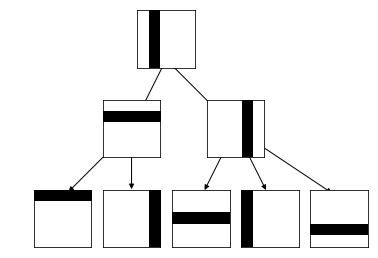

In [83]:
G = nx.DiGraph()
G.add_node(1, image='figures/z1.png')
G.add_node(2, image='figures/z2.png')
G.add_node(3, image='figures/z3.png')
G.add_node(4, image='figures/z4.png')
G.add_node(5, image='figures/z5.png')
G.add_node(6, image='figures/z6.png')
G.add_node(7, image='figures/z7.png')
G.add_node(8, image='figures/z8.png')

G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(2, 4)
G.add_edge(2, 5)
G.add_edge(3, 6)
G.add_edge(3, 7)
G.add_edge(3, 8)

fig : plt.Figure = plt.figure()
plot_image_hierarchy(fig, G)
fig.show()